In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
import numpy as np

from sklearn.decomposition import PCA
import random 
import itertools

# SVM packages
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn import grid_search

# Tree methods
from sklearn.tree import DecisionTreeClassifier

#K nearest neightbout
from sklearn.neighbors import KNeighborsClassifier 

#Traditional approaches
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Ensembl methods: Adaboost & Gradient Boosting & RF
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cross_validation import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from scipy import interp

In [2]:
Negatives = pd.read_csv('50000_HighQualNeg_IMPUTED.csv', sep="\t") #index_col=False
Positive_cat_dat = pd.read_csv('Stage2_output_datcat.csv', sep="\t") #index_col=False
Positive_num = pd.read_csv('Stage3_num_partially_IMPUTED.csv', sep="\t") #index_col=False

In [3]:
# A little preprocessing.
new_df = pd.merge(Positive_cat_dat, Positive_num, on=Positive_num.Id)
new_df = new_df.drop(['Id_y', 'Response_y'], axis=1)
Positives = new_df.rename(columns={'Id_x': 'Id', 'Response_x': 'Response'})
#set(Negatives.columns) - set(new_df.columns)
Negatives = Negatives.drop(['Id.1', 'Response.1'], axis=1)

In [4]:
rows = random.sample(Negatives.index, 20000)
Negative_s = Negatives.ix[rows]

In [5]:
# combine positive and negatives
frames = [Negative_s, Positives]
data = pd.concat(frames)


In [6]:
#Split data into train-test vs hold Out set
X = data.drop('Response', 1)         
Y = data['Response']        

In [ ]:
# create list of numeric features only - no reponse or ID

In [7]:
num_feats = list(Positive_num.columns)[1:165]

In [8]:
# Normlize the data 
for i in range(1,(len(num_feats)-1)):
    feat = num_feats[i]
    Xx = X[feat]
    X[feat]=(X[feat]-X[feat].min())/(X[feat].max()-X[feat].min()) # sklearn scalers do not handle Nans


In [9]:
X_data, X_HODL, y_data, y_HODL = train_test_split(X, Y, test_size= 0.2, random_state = 888)

#  Strategy 1. Fill in remaining Nas with zeros

In [10]:
catdat_cols = list(Positive_cat_dat.columns)
catdat_cols = catdat_cols[1:(len(catdat_cols)-1)]
X_data.loc[:,catdat_cols]= X_data.loc[:,catdat_cols].replace("T1",1)
X_HODL.loc[:,catdat_cols]= X_HODL.loc[:,catdat_cols].replace("T1",1)
Xx_zeroFill = X_data.fillna(0)
Xh_zeroFill = X_HODL.fillna(0)

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Strategy 2. Fill in Nas with zero and do PCA

In [11]:
X_numeric = X_data.loc[:,list(Positive_num.columns)[1:165]] # Removes ID column
X_numeric = X_numeric.fillna(0)
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_numeric)
#X_numeric2 = X_HODL.loc[:,list(Positive_num.columns)[1:165]] 
#X_numeric2 = X_numeric2.fillna(0)
X_pca = pca.transform(X_numeric)
explained_variance = pca.explained_variance_ratio_ #contain percentage of variance explained by each of the extracted principle componenets
cumulative_explained_variance = np.cumsum(explained_variance)
#print(cumulative_explained_variance)
print cumulative_explained_variance[0:26] # 26 PC's can cumulatively explain ~0.9 of variance.

[ 0.27422423  0.38555302  0.46017957  0.50301588  0.5413331   0.57396498
  0.60440323  0.63347587  0.66069297  0.68520672  0.70876641  0.72959939
  0.74938799  0.76748124  0.78504989  0.80121574  0.81590675  0.82921089
  0.84201928  0.85418203  0.86518904  0.87489104  0.88379297  0.89198894
  0.90003664  0.90741044]


In [12]:
Xx_Top_PCA = pd.DataFrame(X_pca).iloc[:,0:26]

In [13]:
X_numeric2 = X_HODL.loc[:,list(Positive_num.columns)[1:165]] 
X_numeric2 = X_numeric2.fillna(0)
X2_pca = pca.transform(X_numeric2)

In [14]:
Xh_Top_PCA = pd.DataFrame(X2_pca).iloc[:,0:26]

# Strategy 3. Remove Nas .... 

If more time, explore just effect of numerics/categorical/date rows indepent of counter parts
and could remove only Nas in given part.
Could also remove rows with Na.

In [15]:
Xx_drop= X_data.dropna(axis='columns') # drop columns with Nas.
Xh_drop= X_HODL.dropna(axis='columns') # drop columns with Nas.

In [16]:
col_dif = list(set(Xh_drop.columns) - set(Xx_drop.columns))
#set(Xx_drop.columns) - set(Xh_drop.columns)

In [17]:
Xh_drop = Xh_drop.drop(col_dif, axis=1)

# Set up initial classification exploration

## Undersample the majority class in the training set

In [18]:
train_drop = Xx_drop.join(y_data)
train_drop = train_drop.drop("Id", axis=1)

In [19]:
train_zero_fill = Xx_zeroFill.join(y_data)
train_zero_fill = train_zero_fill.drop("Id", axis=1)

In [20]:
train_pca = Xx_Top_PCA.join(y_data)

# Preprocessing for Na columns dropped data

In [21]:
train_drop = train_drop.reset_index()

In [22]:
train_drop = train_drop.drop("index", axis=1)

In [23]:
MajorityClass_ind = train_drop.index[train_drop['Response'] == 0].tolist()

In [24]:
MinorityClass_ind = train_drop.index[train_drop['Response'] == 1].tolist()

In [25]:
len(MinorityClass_ind)

1888

In [26]:
downSampIndexes = random.sample(MajorityClass_ind, 1910)

In [27]:
trainInd = MinorityClass_ind + downSampIndexes

In [28]:
trainInd = trainInd[0:3820]

In [29]:
traindrop_DS = train_drop.iloc[trainInd, :]

In [30]:
Xs = traindrop_DS.drop('Response', 1)         
Ys = traindrop_DS['Response'] 

In [31]:
Xh_drop_test = Xh_drop.drop('Id', 1)

# Fit initial models

In [32]:
mod1 = LogisticRegression()
mod2 = GaussianNB()
mod3 = SVC(kernel = "linear")
mod4 = SVC(kernel = "poly", degree=2)
mod5 = SVC(kernel = "poly", degree=3)
mod6 = SVC(kernel = "rbf")
mod7 = DecisionTreeClassifier(criterion= "gini")
mod8 = DecisionTreeClassifier(criterion= "entropy")
mod9 = RandomForestClassifier(criterion="gini")
mod10 = RandomForestClassifier(criterion="entropy")
mod11 = KNeighborsClassifier(n_neighbors = 5)  
mod12 = KNeighborsClassifier(n_neighbors = 10)  
mod13 = KNeighborsClassifier(n_neighbors = 100)  
mod14 = AdaBoostClassifier()
mod15 = GradientBoostingClassifier()

In [33]:
clfL = [mod1, mod2, mod3, mod4, mod5, mod6, mod7, mod8, mod9, mod10, mod11, mod12, mod13, mod14, mod15]

In [34]:
modName = ["LogReg", "NaiveBay", "SVM_linear", "SVM_poly2", "SVM_poly3", "SVM_rbf", "DT_gini", "DT_ent", "RF_gini", "RF_ent", "KNN_5", "KNN_10", "KNN_100", "Ada", "GB"]

# Initial exploration of Na Columns Dropped dataset

In [35]:
def intial_tester(XtrainIn, ytrainIn, XtestIn, ytestIn):
    
    for ind in range(0,len(clfL)):
        clf =clfL[ind]
        moddy = clf.fit(XtrainIn, ytrainIn)
        pred_y = moddy.predict(XtestIn)
        #print pred_y
        acc = accuracy_score(y_true=ytestIn, y_pred=pred_y)
        mod_titl = modName[ind]
        print("%s : %s" % (mod_titl, acc))
    


In [265]:
intial_tester(XtrainIn= Xs, ytrainIn=Ys, XtestIn=Xh_drop_test, ytestIn=y_HODL)

LogReg : 0.894338757736
NaiveBay : 0.914737565895
SVM_linear : 0.940637176255
SVM_poly2 : 0.779738711895
SVM_poly3 : 0.925968370387
SVM_rbf : 0.920009168004
DT_gini : 0.935594774238
DT_ent : 0.933531973413
RF_gini : 0.927114370846
RF_ent : 0.947971579189
KNN_5 : 0.868897547559
KNN_10 : 0.91267476507
KNN_100 : 0.895484758194
Ada : 0.949117579647
GB : 0.981663992666


# Conclusion for Na's dropped data set
+ Of all the methods - Ensembl methods produce best acc - Gradient Boosting, Adaboosting and Random forest (entropy)
+ of all the standard ML methods - SVM linear + Decesion Tree (entropy)

In [36]:
def PreprocessData(trainIn):
    dataIndexReset = trainIn.reset_index()
    dataIndexReset = dataIndexReset.drop("index", axis=1)
    MajorityClass_ind = dataIndexReset.index[dataIndexReset['Response'] == 0].tolist()
    MinorityClass_ind = dataIndexReset.index[dataIndexReset['Response'] == 1].tolist()
    downSampIndexes = random.sample(MajorityClass_ind, 1910)
    trainInd = MinorityClass_ind + downSampIndexes
    trainInd = trainInd[0:len(trainInd)]
    trainer = trainIn.iloc[trainInd, :]
    Xout = traindrop_DS.drop('Response', 1)         
    Yout = traindrop_DS['Response'] 
    #Xout = Xout.drop('Id', 1)#
    return [Xout, Yout]

# Initial Exploration of Nas replaced by zero dataset

In [40]:
zero_x , zero_y = PreprocessData(train_zero_fill)


In [41]:
intial_tester(XtrainIn= zero_x, ytrainIn=zero_y, XtestIn=Xh_drop_test, ytestIn=y_HODL)

LogReg : 0.900297960119
NaiveBay : 0.920238368095
SVM_linear : 0.939720375888
SVM_poly2 : 0.785239514096
SVM_poly3 : 0.924822369929
SVM_rbf : 0.939261975705
DT_gini : 0.934677973871
DT_ent : 0.920467568187
RF_gini : 0.953243181297
RF_ent : 0.946596378639
KNN_5 : 0.881503552601
KNN_10 : 0.925968370387
KNN_100 : 0.912445564978
Ada : 0.953930781572
GB : 0.991290396516


# Conclusion :
+ This is a good sign - even when the Nas are not removed - but simply replaced with zero, the performance does not seem to decrease drastically.
+ Although is this simply because the current dataset was taken from the highest quality samples from the original dataset? 
+ How well will this approach evaluate when poorer quality samples with more Nas are used?

# Initial Exploration of Nas replaced by PCA dataset

In [38]:
pca_x, pca_y = PreprocessData(train_pca)

In [269]:
intial_tester(XtrainIn= pca_x, ytrainIn=pca_y , XtestIn=Xh_drop_test, ytestIn=y_HODL)

LogReg : 0.894338757736
NaiveBay : 0.914737565895
SVM_linear : 0.940637176255
SVM_poly2 : 0.779738711895
SVM_poly3 : 0.925968370387
SVM_rbf : 0.920009168004
DT_gini : 0.93719917488
DT_ent : 0.930552372221
RF_gini : 0.956451982581
RF_ent : 0.940407976163
KNN_5 : 0.868897547559
KNN_10 : 0.91267476507
KNN_100 : 0.895484758194
Ada : 0.949117579647
GB : 0.981893192757


# Conclusion :
+ Once again, PCA does not make a huge difference to results. 
+ Once again, this maybe because of the bias generated due to using only high quality data...
+ Are the accuracy scores true respentative of the models ability to generalize? - We are only testing on high quality data. 

# Concluding the initial stage of tests:
+ All 3 approaches to handling Nas seem to produce similar results
+ Ensembl methods are performing very well as expected
+ SVM linear + Decision trees are performing well too. 

# 3 fold- 5 fold-7 fold CROSS VALIDATION 

In [39]:
pca_data = pca_x.join(pca_y) 

In [40]:
X_train_, X_test_, y_train_, y_test_= train_test_split(pca_x, pca_y, test_size= 0.2, random_state = 888)

In [45]:
def DoDTree(X_trainIn, y_trainIn, X_testIn):
    model = DecisionTreeClassifier(criterion= "gini")
    model.fit(X_trainIn, y_trainIn)
    D_y_predictions = model.predict(X_testIn)
    return(D_y_predictions)

In [43]:
def DoGB(X_trainIn, y_trainIn, X_testIn):
    model = GradientBoostingClassifier()
    model.fit(X_trainIn, y_trainIn)
    D_y_predictions = model.predict(X_testIn)
    return(D_y_predictions)

In [48]:
y_pred_ = DoDTree(X_trainIn=X_train_, y_trainIn=y_train_, X_testIn=X_test_)

In [42]:
# Function to create a confusion matrix
def DoConfMat(yTestIn, yPredIn):
    Confusion_M1 = confusion_matrix(yTestIn, yPredIn) #.ravel()
    tn = Confusion_M1[0][0]
    fp = Confusion_M1[0][1]
    fn = Confusion_M1[1][0]
    tp = Confusion_M1[1][1]
    
    ALL1 = tn + fp + fn + tp 
    stat_accuracy1 = float(tp + tn)/ALL1
    stat_misclassification_rate1 = float(fp + fn) / ALL1
    stat_false_negative1 = float(fn) / (tp + fn) # false negative rate
    stat_false_positive1 = float(fp) / (fp + tn) # false positive rate
    stat_sensitivity1 = float(tp) / (tp + fn) # false negative rate
    stat_specificity1 = float(tn) / (tn + fp)
    stat_precision1  = float(tp)/(tp+fp)
    
    return(stat_accuracy1, stat_misclassification_rate1, stat_sensitivity1, stat_false_positive1, stat_specificity1, stat_false_negative1, stat_precision1)
    
    

In [50]:
accuracy_score(y_true=y_test_, y_pred=y_pred_)

0.80289093298291725

In [51]:
DoConfMat(y_test_, y_pred_)

(0.8028909329829172,
 0.19710906701708278,
 0.7049180327868853,
 0.10632911392405063,
 0.8936708860759494,
 0.29508196721311475,
 0.86)

In [44]:
def cross_validate_roc(mydataIn, num_k_param):
    mydataIn = mydataIn.sample(frac=1) # randomly shuffle data, frac parameter define what fraction of data to return - frac= 1  means we return all data shuffled
    folds = np.array_split(mydataIn, num_k_param)
    num_k = int(len(folds)) 
    
    mean_true_positive_rate = 0
    mean_false_positive_rate = np.linspace(0, 1, 100)
    all_true_positive_rate = []
    

    CV_accuracy = []
    CV_misclassification = []
    CV_sensitivity = []
    CV_false_positive = []
    CV_specificity = []
    CV_false_negative = []
    CV_precision = []
    
    # K fold cross validation
    for i in range(0,num_k):
        Ktest = folds[i]
        Ktrain = []
        for j in xrange(len(folds)):
            if j != i:
                Ktrain.append(folds[j])  
        Ktrain = pd.concat(Ktrain)
        
        KX_train = Ktrain.drop('Response', 1)         
        KX_test = Ktest.drop('Response',1)              
        Ky_train = Ktrain['Response'] 
        Ky_test = Ktest['Response'] 
    
        #outty = DoDTree(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test)
        outty = DoGB(X_trainIn=KX_train, y_trainIn=Ky_train, X_testIn=KX_test)
        Ky_predictions = outty
    
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(Ky_test, Ky_predictions)  # added thresholds without TEST!!!!! - will it mess up program?!?!?!?
        roc_auc = metrics.auc(false_positive_rate,true_positive_rate)
    
        Kclassification_stats = DoConfMat(Ky_test, Ky_predictions)
        CV_accuracy.append(Kclassification_stats[0])
        CV_misclassification.append(Kclassification_stats[1])
        CV_sensitivity.append(Kclassification_stats[2])
        CV_false_positive.append(Kclassification_stats[3])
        CV_specificity.append(Kclassification_stats[4])
        CV_false_negative.append(Kclassification_stats[5])
        CV_precision.append(Kclassification_stats[6])
        
        mean_true_positive_rate += interp(mean_false_positive_rate, false_positive_rate, true_positive_rate)
        mean_true_positive_rate[0] = 0
    
    #calculate mean AUC
    mean_true_positive_rate /= num_k
    mean_true_positive_rate[-1] = 1
    mean_auc = auc(mean_false_positive_rate, mean_true_positive_rate)
    

    stat_accuracy2 = sum(CV_accuracy)/len(CV_accuracy)
    stat_misclassification_rate2 = sum(CV_misclassification)/len(CV_misclassification) 
    stat_sensitivity2 = sum(CV_sensitivity)/len(CV_sensitivity)	
    stat_false_positive2 = sum(CV_false_positive)/len(CV_false_positive) 
    stat_specificity2 = sum(CV_specificity)/len(CV_specificity) 
    stat_false_negative2 = sum(CV_false_negative)/len(CV_false_negative) 
    stat_precision2 = sum(CV_precision)/len(CV_precision)
    
    #print("AUC: ", mean_auc)
    #print("K fold mean Accuracy: ", stat_accuracy2)
    #print("K fold mean Misclassification rate: ", stat_misclassification_rate2)
    #print("K fold Sensitivity (True Positives): ", stat_sensitivity2)
    #print("K fold False Positive:", stat_false_positive2)
    #print("K fold Specificity (True Negatives): ", stat_specificity2)
    #print("K fold False Negatives: ", stat_false_negative2)
    #print("K fold Precision: :", stat_precision2)
    
    return [mean_auc, stat_accuracy2, stat_misclassification_rate2, stat_sensitivity2, stat_false_positive2, stat_specificity2, stat_false_positive2, stat_specificity2,stat_false_negative2, stat_precision2]


In [48]:
 cross_validate_roc(mydataIn=pca_data, num_k_param=3)

[0.85384928478101296,
 0.8541337546076883,
 0.14586624539231174,
 0.7643852880658436,
 0.05645622048115922,
 0.9435437795188407,
 0.05645622048115922,
 0.9435437795188407,
 0.23561471193415637,
 0.9303024995938921]

In [49]:
 cross_validate_roc(mydataIn=pca_data, num_k_param=5)

[0.85860369902851053,
 0.8588755980861243,
 0.1411244019138756,
 0.7609416657843049,
 0.0435332462805004,
 0.9564667537194996,
 0.0435332462805004,
 0.9564667537194996,
 0.23905833421569503,
 0.9445243287839892]

In [50]:
 cross_validate_roc(mydataIn=pca_data, num_k_param=7)

[0.85819090385434071,
 0.8580685214902662,
 0.1419314785097338,
 0.765205537871182,
 0.04861879941953735,
 0.9513812005804627,
 0.04861879941953735,
 0.9513812005804627,
 0.23479446212881813,
 0.9393350386197266]

In [175]:
 cross_validate_roc(mydataIn=pca_data, num_k_param=10)

('K fold mean Accuracy: ', 0.7842878850669982)
('K fold mean Misclassification rate: ', 0.21571211493300177)
('K fold Sensitivity (True Positives): ', 0.6989173465347752)
('K fold False Positive:', 0.13239471165052796)
('K fold Specificity (True Negatives): ', 0.8676052883494721)
('K fold False Negatives: ', 0.3010826534652248)
('K fold Precision: :', 0.8412463845070883)


In [185]:
cross_validate_roc(mydataIn=pca_data, num_k_param=30)

('AUC: ', 0.78246082765536951)
('K fold mean Accuracy: ', 0.7829792109319668)
('K fold mean Misclassification rate: ', 0.2170207890680331)
('K fold Sensitivity (True Positives): ', 0.6930445751898611)
('K fold False Positive:', 0.1280261616462378)
('K fold Specificity (True Negatives): ', 0.8719738383537622)
('K fold False Negatives: ', 0.3069554248101387)
('K fold Precision: :', 0.8414457922782581)


# Feature Selection with Genetic Algorithm

In [ ]:
## Initialize the population
### This function should be run once to begin the genetic algorithm
### parameters: 
### 1. DataIn - the whole dataset including all Y and X values
### 2. No.individuals - the number of times a set of features are created
### 3. No.matings - number of top features chosen for next step.
###    condition:  No.individuals > No.matings
###    condition: No.matings should be an even number

In [72]:
def InitializeIt(XIn, YIn, Num_creations):
    local_col_index = []
    local_acc = []
    for i in range(0, Num_creations):
        num_indexes_to_sample = random.sample(list(range(30,80)), 1)
        columns_index_sample = random.sample(list(range(0, len(XIn.columns))), num_indexes_to_sample[0])
        XIn_samp = XIn.iloc[:,columns_index_sample]
        Xy_In = pd.concat([XIn_samp,YIn], axis = 1)
        acc_score = cross_validate_roc(mydataIn=Xy_In, num_k_param=3)
        local_acc.append(acc_score[1])
        local_col_index.append(columns_index_sample)
        
    sorted_acc, sorted_col_index = zip(*sorted(zip(local_acc, local_col_index)))
    #print sorted_acc[-21:-1]
    #print sorted_col_index[-21:-1] # top 10
    return sorted_col_index[-21:-1]
    

In [77]:
test_GA_1 = InitializeIt(XIn=zero_x, YIn=zero_y, Num_creations=30)

In [83]:
#### CROSS OVER 

### cross_over_rate - smaller the number, the more will be subsetted out of features + more diversification
def Cross(Indexes1In, Indexes2In, cross_over_rate):
    sample_to_cross_index = round(len(Indexes1In)/cross_over_rate)
    samp_to_cross1 = np.random.choice(Indexes1In, int(sample_to_cross_index), replace=False)
    samp_to_cross2 = np.random.choice(Indexes2In, int(sample_to_cross_index), replace=False)
    samp_to_keep1 = np.setdiff1d(Indexes1In, samp_to_cross1)
    samp_to_keep2 = np.setdiff1d(Indexes2In, samp_to_cross2)
    child1 = samp_to_cross1.tolist() + samp_to_keep2.tolist()
    child2 = samp_to_cross2.tolist() + samp_to_keep1.tolist()
    return (child1,child2)
    


In [ ]:
cross_out = Cross(Indexes1In=test_GA_1[1], Indexes2In=test_GA_1[5], cross_over_rate=3) # cross over 1/3 of samps

In [84]:
def Mutate(IndexesIn, no_elements_to_mutate, OriginalXFeatures):

    no_elements_to_keep = len(IndexesIn) - no_elements_to_mutate
    Natives = random.sample(IndexesIn, no_elements_to_keep) # keepers
    Feats = range(0, len(OriginalXFeatures.columns)-1) 
    mutant_pool = np.setdiff1d(Feats,Natives)  # Sample from only non-native features
    Mutants= random.sample(mutant_pool, no_elements_to_mutate) # sample from non-native fetures
    mutated_output = Natives + Mutants
    
    return mutated_output
    


In [ ]:
mut_out = Mutate(cross_out[0], no_elements_to_mutate=4, OriginalXFeatures=zero_x)

In [85]:
def Breeding(breedersIn, no_elements_to_mutate,OriginalXFeatures, cross_over_rate):
    NextGeneration = []
    #print breedersIn
    random.shuffle(breedersIn)
    for i in range(0, len(breedersIn), 2):
        breeder1 = breedersIn[i]
        breeder2 = breedersIn[i+1]
        cross_out = Cross(Indexes1In=breeder1, Indexes2In=breeder2, cross_over_rate=cross_over_rate) # cross over 1/3 of samps
        child1 = Mutate(cross_out[0], no_elements_to_mutate=4, OriginalXFeatures=OriginalXFeatures)
        child2 = Mutate(cross_out[1], no_elements_to_mutate=4, OriginalXFeatures=OriginalXFeatures)
        NextGeneration.append(child1)
        NextGeneration.append(child2)
    return NextGeneration

In [ ]:
NextGen= Breeding(breedersIn=list(test_GA_1), no_elements_to_mutate=3, OriginalXFeatures=zero_x, cross_over_rate=3)


In [86]:
def OneGeneration_LifeCycle(generationIn, XIn, yIn):
    acc_collect = []
    features_collect = []
    for i in range(0, len(generationIn)):
        XIn_samp = XIn.iloc[:,generationIn[i]]
        Xy_In = pd.concat([XIn_samp,yIn], axis = 1).dropna(how="any")
        
        acc_score = cross_validate_roc(mydataIn=Xy_In, num_k_param=3)
        acc_collect.append(acc_score[1])
        features_collect.append(generationIn[i])
    
    sorted_acc, sorted_col_index = zip(*sorted(zip(acc_collect, features_collect)))
    
    top_acc = list(reversed(sorted_acc))[0:10]
    top_indexes = list(reversed(sorted_col_index))[0:10] # top 10
    return [top_acc, top_indexes]

In [265]:
one_gen_out = OneGeneration_LifeCycle(generationIn=NextGen, XIn=zero_x, yIn=zero_y)

In [87]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]


In [88]:
def GeneticAlgo(dataIn, breedersIn, TotalCycles, mutation_rate, cross_over_rate):
    Best_features_ever = []
    Best_accuracy_ever = 0
    
    First_Input = breedersIn 
    Accuracy_across_time = []
    Best_acc_across_time = []
    for i in range(0, TotalCycles):
        Xx = dataIn.iloc[:,:-1]
        Yy = dataIn.iloc[:,-1]
        one_gen_out = OneGeneration_LifeCycle(generationIn=First_Input, XIn=Xx, yIn=Yy)
        gen_accs= one_gen_out[0]
        gen_acc_best= gen_accs[0]
        gen_feat = one_gen_out[1]
        Accuracy_across_time.append(gen_acc_best)
        
        if Best_accuracy_ever < gen_acc_best:
            Best_accuracy_ever = gen_acc_best
            Best_features_ever = gen_feat[0]
        
        Best_acc_across_time.append(Best_accuracy_ever)
        
        # dynamically change mutation and cross over rate depending on homogeneity
        flat_pop = flatten(one_gen_out)
        homog = float(len(set(flat_pop)))/float(len(flat_pop)) # 1 = many individuals, ~0 = many duplicates
        
        if homog > 0.9:
            mutation_rate = 4
            cross_over_rate = 4
        elif homog > 0.75:
            mutation_rate = 12
            cross_over_rate = 7
        elif homog > 0.5:
            mutation_rate = 15
            cross_over_rate = 10
        elif homog > 0.25:
            mutation_rate = 20
            cross_over_rate = 12
        elif homog > 0.1:
            mutation_rate = 25
            cross_over_rate = 15
        else:
            mutation_rate = 28
            cross_over_rate = 25
            
        NextGen= Breeding(breedersIn=list(gen_feat), no_elements_to_mutate=mutation_rate, OriginalXFeatures=Xx, cross_over_rate=cross_over_rate)
        First_Input = tuple(NextGen)
    
    return [Best_features_ever, Best_accuracy_ever, Accuracy_across_time, Best_acc_across_time]
 


In [89]:
GeneticOutput = GeneticAlgo(dataIn=train_zero_fill, breedersIn= test_GA_1, TotalCycles=50, mutation_rate=4, cross_over_rate=4)

In [92]:
chosen_feats = GeneticOutput[0]

In [97]:
chosen_feats.append(344)

In [99]:
FeatSelectedZeroFills = train_zero_fill.iloc[:, chosen_feats]

In [103]:
train_zero_fill.to_csv("featSelected_zeroFill_data", sep="\t")

In [101]:
improve = GeneticOutput[3]

In [124]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 5

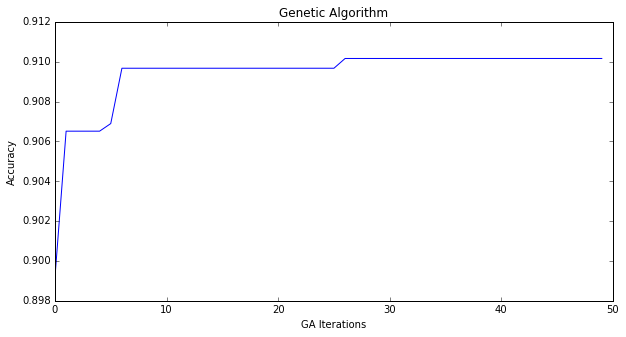

In [126]:
plt.plot(improve)
plt.ylabel('Accuracy')
plt.xlabel('GA Iterations')
plt.title("Genetic Algorithm")

In [ ]:
 #.join(y_HODL)

In [128]:
heldX = Xh_zeroFill.iloc[:, chosen_feats]

In [129]:
HODL_out = heldX.join(y_HODL)

In [130]:
HODL_out.to_csv("featSelected_zeroFill_HODL", sep="\t")